In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets sentence-transformers

In [ ]:
!pip install datasets

In [52]:
save_path = "/content/drive/MyDrive/LLM Project/finetuned_chinese_roberta"

# Save model and tokenizer
model.save_pretrained(save_path)

In [12]:
from sentence_transformers import SentenceTransformer

load_path = "/content/drive/MyDrive/LLM Project/finetuned_chinese_roberta"
model = SentenceTransformer(load_path)

In [14]:
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics import f1_score, classification_report
from collections import Counter

# =================== Load and Prepare Data ===================
with open("training_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

examples = [
    InputExample(texts=[entry[0]['lyrics'], entry[1]['lyrics']], label=float(entry[2]))
    for entry in data
]

labels_all = [int(entry[2]) for entry in data]
label_counter = Counter(labels_all)
print("Label distribution:", label_counter)

# Split data - stratify to maintain class balance
train_data, val_data = train_test_split(examples, test_size=0.2, random_state=42, stratify=labels_all)
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")

# =================== Create Model ===================
model = SentenceTransformer('hfl/chinese-roberta-wwm-ext')

# =================== Evaluation Setup ===================
val_sentences1 = [ex.texts[0] for ex in val_data]
val_sentences2 = [ex.texts[1] for ex in val_data]
val_scores = [ex.label for ex in val_data]

evaluator = EmbeddingSimilarityEvaluator(
    val_sentences1,
    val_sentences2,
    val_scores,
    name="lyrics-eval"
)

# =================== Define Loss ===================
class ThresholdFindingCallback:
    def __init__(self, model, val_sentences1, val_sentences2, val_scores):
        self.model = model
        self.val_sentences1 = val_sentences1
        self.val_sentences2 = val_sentences2
        self.val_scores = torch.tensor(val_scores, dtype=torch.float)
        self.best_f1 = 0
        self.best_threshold = 0.5
        # Store val data for threshold tuning
        self.val_labels = [int(score) for score in val_scores]

    def __call__(self, score, epoch, steps):
        self.model.eval()
        with torch.no_grad():
            # Get embeddings and compute cosine similarities
            emb1 = self.model.encode(self.val_sentences1, convert_to_tensor=True)
            emb2 = self.model.encode(self.val_sentences2, convert_to_tensor=True)
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            cos_sim_np = cos_sim.cpu().numpy()

            # Find best threshold
            best_f1 = 0
            best_thresh = 0.5

            # For lyrics similarity classification:
            # - Higher similarity (above threshold) should predict class 0 (similar)
            # - Lower similarity (below threshold) should predict class 1 (different)
            for t in np.arange(0.3, 0.95, 0.01):
                preds = [0 if s > t else 1 for s in cos_sim_np]
                f1 = f1_score(self.val_labels, preds, average="macro")
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = t

            # Save best threshold so far
            if best_f1 > self.best_f1:
                self.best_f1 = best_f1
                self.best_threshold = best_thresh

            # Output progress
            print(f"[Epoch {epoch}, Step {steps}] Pearson: {score:.4f} | Best threshold: {self.best_threshold:.2f} (F1: {self.best_f1:.4f})")

            # Output detailed metrics occasionally
            if steps % 100 == 0 or (epoch == 1 and steps <= 10):
                preds = [0 if s > self.best_threshold else 1 for s in cos_sim_np]
                print(classification_report(self.val_labels, preds))

                # Plot threshold tuning curve
                if steps % 500 == 0:
                    thresholds = np.arange(0.3, 0.95, 0.02)
                    f1_scores = []

                    for t in thresholds:
                        preds = [0 if s > t else 1 for s in cos_sim_np]
                        f1 = f1_score(self.val_labels, preds, average="macro")
                        f1_scores.append(f1)

                    plt.figure(figsize=(10, 6))
                    plt.plot(thresholds, f1_scores, '-o')
                    plt.axvline(x=self.best_threshold, color='red', linestyle='--')
                    plt.title(f"F1 Score vs Threshold (Epoch {epoch}, Step {steps})")
                    plt.xlabel("Threshold")
                    plt.ylabel("F1 Score")
                    plt.grid(True)
                    plt.savefig(f"threshold_epoch{epoch}_step{steps}.png")
                    plt.close()

# Create callback
threshold_finder = ThresholdFindingCallback(model, val_sentences1, val_sentences2, val_scores)

# Loss function - using CosineSimilarityLoss which is well-suited for this task
train_loss = losses.CosineSimilarityLoss(model=model)

# =================== DataLoader ===================
# Simple dataloader with shuffling (no weighted sampling needed since balanced data)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=32)
print(f"Train dataloader created with {len(train_data)} examples")

# =================== Train the Model ===================
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=5,
    warmup_steps=100,
    evaluation_steps=50,
    output_path='./chinese_roberta_lyrics_contrastive',
    show_progress_bar=True,
    callback=threshold_finder,
    optimizer_params={'lr': 2e-5},
    save_best_model=True
)

# =================== Save best threshold ===================
# Save the best threshold for later use in evaluation
threshold_info = {
    "best_threshold": threshold_finder.best_threshold,
    "best_f1": threshold_finder.best_f1
}

with open('./chinese_roberta_lyrics_contrastive/threshold_info.json', 'w') as f:
    json.dump(threshold_info, f)

print(f"\n✅ Best threshold: {threshold_finder.best_threshold:.2f}, F1 Macro: {threshold_finder.best_f1:.4f}")


Label distribution: Counter({0: 489, 1: 486})
Training set size: 780, Validation set size: 195


Train dataloader created with 780 examples


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Lyrics-eval Pearson Cosine,Lyrics-eval Spearman Cosine
25,No log,No log,0.425560,0.445312
50,No log,No log,0.464608,0.469545


[Epoch 1.0, Step 25] Pearson: 0.4453 | Best threshold: 0.70 (F1: 0.3510)
[Epoch 2.0, Step 50] Pearson: 0.4695 | Best threshold: 0.30 (F1: 0.3669)
[Epoch 2.0, Step 50] Pearson: 0.4695 | Best threshold: 0.30 (F1: 0.3669)


Step,Training Loss,Validation Loss,Lyrics-eval Pearson Cosine,Lyrics-eval Spearman Cosine
25,No log,No log,0.425560,0.445312
50,No log,No log,0.464608,0.469545
75,No log,No log,0.495886,0.507262
100,No log,No log,0.451216,0.448409
125,No log,No log,0.509582,0.511088


[Epoch 3.0, Step 75] Pearson: 0.5073 | Best threshold: 0.30 (F1: 0.3669)
[Epoch 4.0, Step 100] Pearson: 0.4484 | Best threshold: 0.30 (F1: 0.3669)
              precision    recall  f1-score   support

           0       0.44      0.68      0.54        98
           1       0.30      0.13      0.18        97

    accuracy                           0.41       195
   macro avg       0.37      0.41      0.36       195
weighted avg       0.37      0.41      0.36       195

[Epoch 4.0, Step 100] Pearson: 0.4484 | Best threshold: 0.30 (F1: 0.3669)
              precision    recall  f1-score   support

           0       0.44      0.68      0.54        98
           1       0.30      0.13      0.18        97

    accuracy                           0.41       195
   macro avg       0.37      0.41      0.36       195
weighted avg       0.37      0.41      0.36       195

[Epoch 5.0, Step 125] Pearson: 0.5111 | Best threshold: 0.30 (F1: 0.3669)

✅ Best threshold: 0.30, F1 Macro: 0.3669


Test data loaded: 244 examples
Labels in testing data: Counter({0: 127, 1: 117})
Loading model from: /content/drive/MyDrive/LLM Project/finetuned_chinese_roberta
Loading base model for comparison



=== Testing different thresholds (FLIPPED LOGIC) ===
    threshold  f1_finetuned  accuracy_finetuned   f1_base  accuracy_base  pred_0_count  pred_1_count
0        0.00      0.324100            0.479508  0.324100       0.479508             0           244
1        0.05      0.324100            0.479508  0.324100       0.479508             0           244
2        0.10      0.324100            0.479508  0.324100       0.479508             0           244
3        0.15      0.324100            0.479508  0.324100       0.479508             0           244
4        0.20      0.324100            0.479508  0.324100       0.479508             0           244
5        0.25      0.324100            0.479508  0.324100       0.479508             0           244
6        0.30      0.324100            0.479508  0.324100       0.479508             0           244
7        0.35      0.324100            0.479508  0.324100       0.479508             0           244
8        0.40      0.324100          

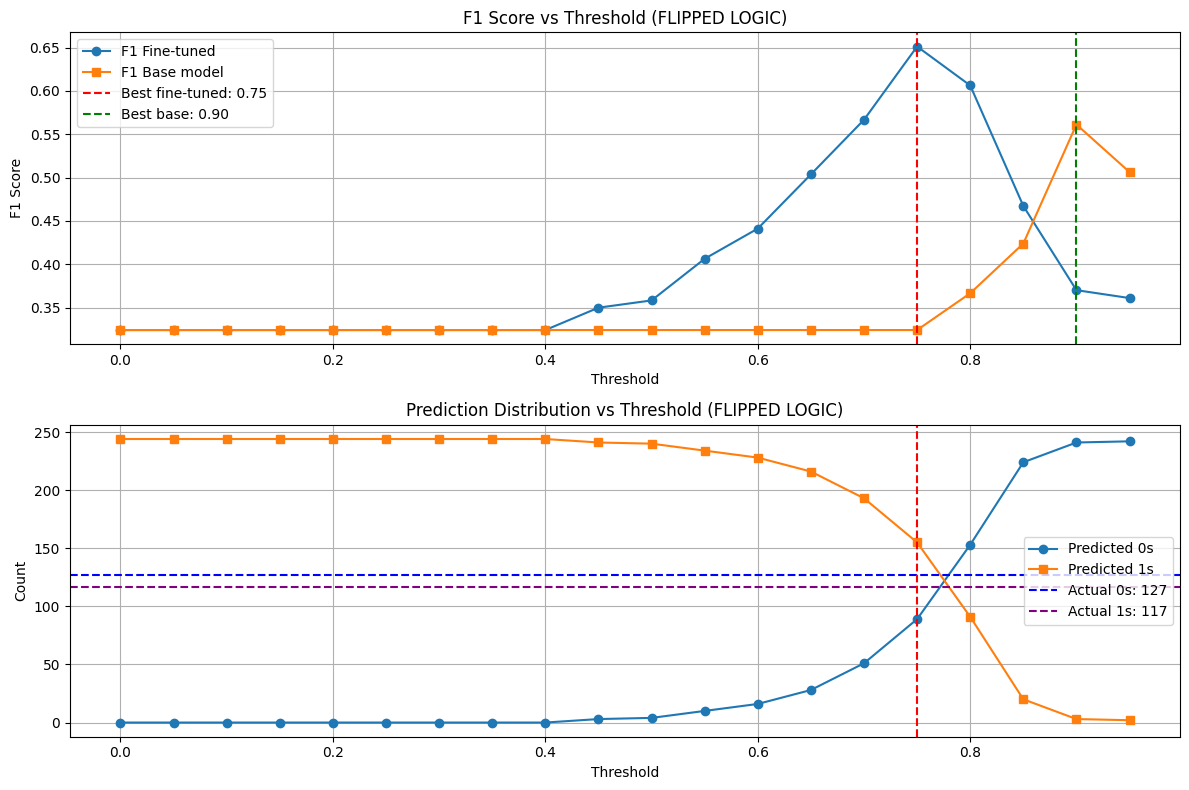

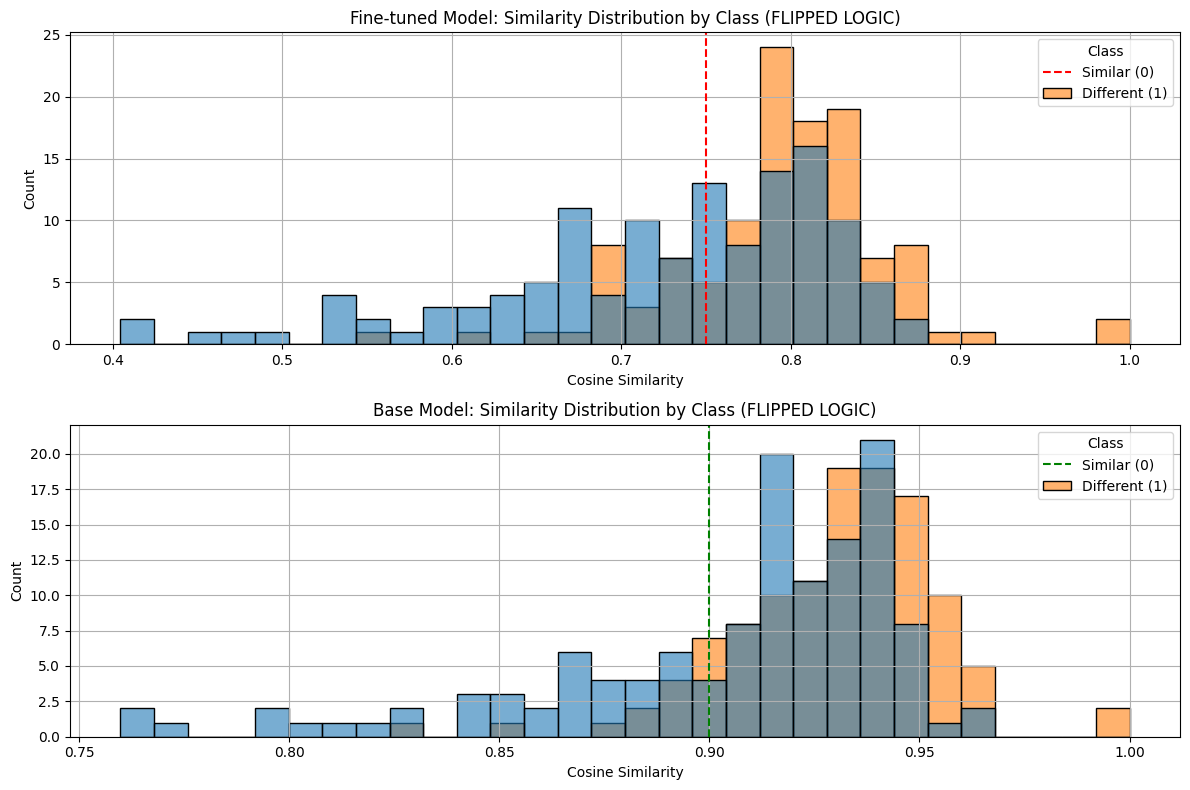

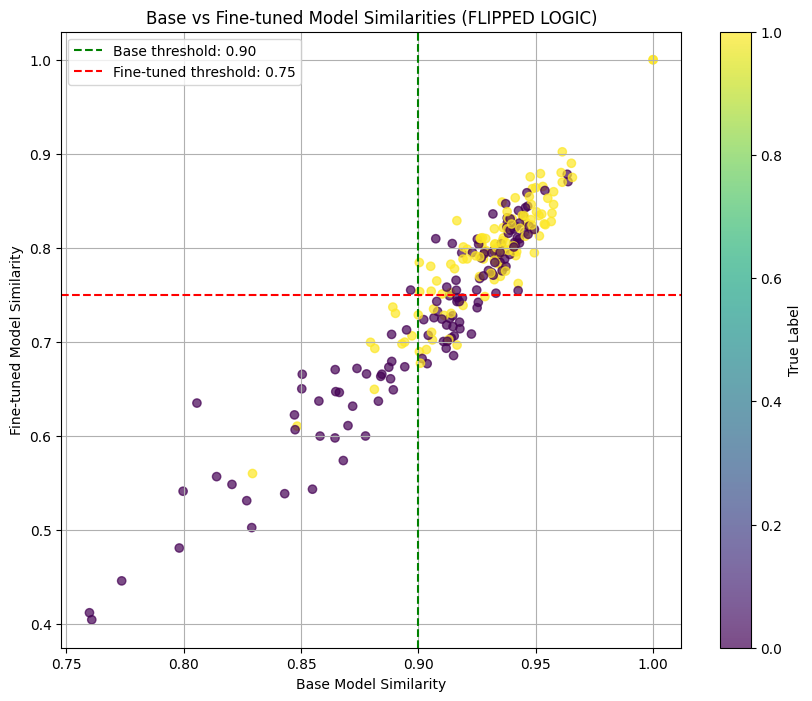


=== Class Separation Analysis (FOR REFERENCE - NOT AFFECTED BY PREDICTION FLIP) ===
Base model:
  Class 0: mean=0.9054, std=0.0420
  Class 1: mean=0.9301, std=0.0247
  Separation: 0.0247

Fine-tuned model:
  Class 0: mean=0.7257, std=0.0986
  Class 1: mean=0.7940, std=0.0635
  Separation: 0.0683

✅ The fine-tuned model has BETTER separation between classes


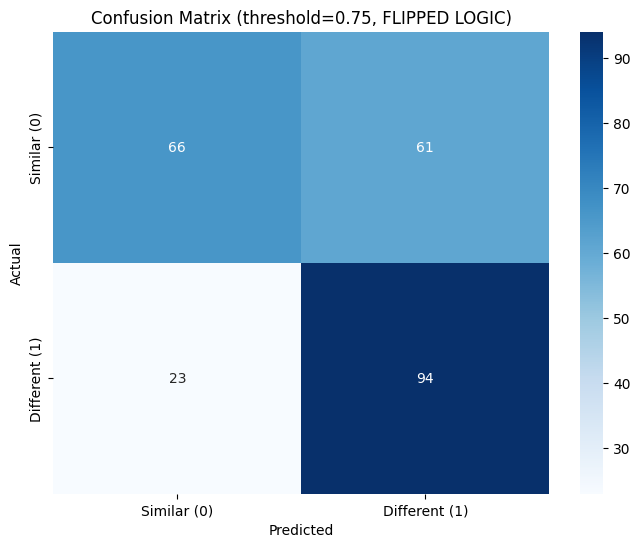


=== Confusion Matrix (FLIPPED LOGIC) ===
[[66 61]
 [23 94]]

=== Classification Report (FLIPPED LOGIC) ===
              precision    recall  f1-score   support

           0       0.74      0.52      0.61       127
           1       0.61      0.80      0.69       117

    accuracy                           0.66       244
   macro avg       0.67      0.66      0.65       244
weighted avg       0.68      0.66      0.65       244


=== Error Analysis (84 errors, 34.4% of data) ===

Errors by true label:
  Class 0: 61 errors out of 127 examples (48.0%)
  Class 1: 23 errors out of 117 examples (19.7%)

Top 5 genres with most errors:
  爱与浪漫: 38 errors out of 113 examples (33.6%)
  生活与反思: 23 errors out of 61 examples (37.7%)
  风景与旅程: 13 errors out of 38 examples (34.2%)
  社会与现实: 8 errors out of 29 examples (27.6%)
  民俗与传统: 2 errors out of 3 examples (66.7%)

Example errors:
Error 1:
  True Label: 1, Predicted: 0
  Fine-tuned Similarity: 0.7021
  Base Model Similarity: 0.9060
  Genre 1: 生活与

In [22]:
import pandas as pd
import torch
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sentence_transformers import SentenceTransformer, util
from sklearn import metrics

# =================== Load Test Data ===================
with open('testing_data_1.json', 'r', encoding='utf-8') as file:
    test_data = json.load(file)

print(f"Test data loaded: {len(test_data)} examples")
label_counter = Counter([int(entry[2]) for entry in test_data])
print(f"Labels in testing data: {label_counter}")

# =================== Load the Model ===================
model_path = "/content/drive/MyDrive/LLM Project/finetuned_chinese_roberta"
print(f"Loading model from: {model_path}")
model = SentenceTransformer(model_path)
model.eval()

# Also load the base model for comparison
print("Loading base model for comparison")
base_model = SentenceTransformer('hfl/chinese-roberta-wwm-ext')
base_model.eval()

# =================== Compute Embeddings and Similarities ===================
results = []

for idx, entry in enumerate(test_data):
    song1, song2, label = entry
    label = int(label)
    lyrics1 = song1['lyrics']
    lyrics2 = song2['lyrics']

    # Get genre and determine mode (per-genre or cross-genre)
    genre1 = song1.get('genre', [])
    genre2 = song2.get('genre', [])
    primary_genre1 = genre1[0] if genre1 else "Unknown"
    primary_genre2 = genre2[0] if genre2 else "Unknown"

    # Determine if this is a same-genre comparison or cross-genre
    if primary_genre1 == primary_genre2:
        mode = "per-genre"
    else:
        mode = "cross-genre"

    # Embeddings from fine-tuned model
    emb1_ft = model.encode(lyrics1, convert_to_tensor=True)
    emb2_ft = model.encode(lyrics2, convert_to_tensor=True)
    cos_sim_ft = util.cos_sim(emb1_ft, emb2_ft).item()

    # Embeddings from base model
    emb1_base = base_model.encode(lyrics1, convert_to_tensor=True)
    emb2_base = base_model.encode(lyrics2, convert_to_tensor=True)
    cos_sim_base = util.cos_sim(emb1_base, emb2_base).item()

    # Store results
    results.append({
        'index': idx,
        'lyrics1_preview': lyrics1[:50] + "...",
        'lyrics2_preview': lyrics2[:50] + "...",
        'true_label': label,
        'genre1': primary_genre1,
        'genre2': primary_genre2,
        'mode': mode,
        'similarity_finetuned': cos_sim_ft,
        'similarity_base': cos_sim_base,
        'sim_difference': cos_sim_ft - cos_sim_base
    })

results_df = pd.DataFrame(results)

# =================== Test Different Thresholds with FLIPPED Logic ===================
print("\n=== Testing different thresholds (FLIPPED LOGIC) ===")
thresholds = np.arange(0.0, 1.0, 0.05)
results_by_threshold = []

for thresh in thresholds:
    # Fine-tuned model predictions - FLIPPED LOGIC: lower similarity means similar (0)
    preds_ft = [0 if sim < thresh else 1 for sim in results_df['similarity_finetuned']]
    f1_ft = metrics.f1_score(results_df['true_label'], preds_ft, average='macro')
    acc_ft = metrics.accuracy_score(results_df['true_label'], preds_ft)
    pred_counts = Counter(preds_ft)

    # Base model predictions - FLIPPED LOGIC
    preds_base = [0 if sim < thresh else 1 for sim in results_df['similarity_base']]
    f1_base = metrics.f1_score(results_df['true_label'], preds_base, average='macro')
    acc_base = metrics.accuracy_score(results_df['true_label'], preds_base)

    results_by_threshold.append({
        'threshold': thresh,
        'f1_finetuned': f1_ft,
        'accuracy_finetuned': acc_ft,
        'f1_base': f1_base,
        'accuracy_base': acc_base,
        'pred_0_count': pred_counts.get(0, 0),
        'pred_1_count': pred_counts.get(1, 0)
    })

thresh_df = pd.DataFrame(results_by_threshold)
print(thresh_df.to_string())

# Find best thresholds
best_thresh_ft = thresh_df.loc[thresh_df['f1_finetuned'].idxmax(), 'threshold']
best_f1_ft = thresh_df.loc[thresh_df['f1_finetuned'].idxmax(), 'f1_finetuned']
best_thresh_base = thresh_df.loc[thresh_df['f1_base'].idxmax(), 'threshold']
best_f1_base = thresh_df.loc[thresh_df['f1_base'].idxmax(), 'f1_base']

print(f"\nBest threshold (fine-tuned): {best_thresh_ft:.2f} with F1: {best_f1_ft:.4f}")
print(f"Best threshold (base): {best_thresh_base:.2f} with F1: {best_f1_base:.4f}")

# =================== Plot Threshold Analysis ===================
plt.figure(figsize=(12, 8))

# Plot F1 scores
plt.subplot(2, 1, 1)
plt.plot(thresh_df['threshold'], thresh_df['f1_finetuned'], 'o-', label='F1 Fine-tuned')
plt.plot(thresh_df['threshold'], thresh_df['f1_base'], 's-', label='F1 Base model')
plt.axvline(x=best_thresh_ft, color='red', linestyle='--', label=f'Best fine-tuned: {best_thresh_ft:.2f}')
plt.axvline(x=best_thresh_base, color='green', linestyle='--', label=f'Best base: {best_thresh_base:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold (FLIPPED LOGIC)')
plt.legend()
plt.grid(True)

# Plot prediction distribution
plt.subplot(2, 1, 2)
plt.plot(thresh_df['threshold'], thresh_df['pred_0_count'], 'o-', label='Predicted 0s')
plt.plot(thresh_df['threshold'], thresh_df['pred_1_count'], 's-', label='Predicted 1s')
plt.axhline(y=label_counter[0], color='blue', linestyle='--', label=f'Actual 0s: {label_counter[0]}')
plt.axhline(y=label_counter[1], color='purple', linestyle='--', label=f'Actual 1s: {label_counter[1]}')
plt.axvline(x=best_thresh_ft, color='red', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('Prediction Distribution vs Threshold (FLIPPED LOGIC)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('threshold_analysis_flipped.png')
plt.show()

# =================== Visualize Similarity Distributions with FLIPPED Logic ===================
plt.figure(figsize=(12, 8))

# Fine-tuned model similarities - note FLIPPED LOGIC in title
plt.subplot(2, 1, 1)
sns.histplot(data=results_df, x='similarity_finetuned', hue='true_label', bins=30, alpha=0.6)
plt.axvline(x=best_thresh_ft, color='red', linestyle='--', label=f'Best threshold: {best_thresh_ft:.2f}')
plt.title("Fine-tuned Model: Similarity Distribution by Class (FLIPPED LOGIC)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.legend(title="Class", labels=["Similar (0)", "Different (1)"])
plt.grid(True)

# Base model similarities - note FLIPPED LOGIC in title
plt.subplot(2, 1, 2)
sns.histplot(data=results_df, x='similarity_base', hue='true_label', bins=30, alpha=0.6)
plt.axvline(x=best_thresh_base, color='green', linestyle='--', label=f'Best threshold: {best_thresh_base:.2f}')
plt.title("Base Model: Similarity Distribution by Class (FLIPPED LOGIC)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.legend(title="Class", labels=["Similar (0)", "Different (1)"])
plt.grid(True)

plt.tight_layout()
plt.savefig('similarity_distributions_flipped.png')
plt.show()

# =================== Compare Fine-tuned vs Base Model ===================
plt.figure(figsize=(10, 8))
plt.scatter(results_df['similarity_base'], results_df['similarity_finetuned'],
           c=results_df['true_label'], cmap='viridis', alpha=0.7)
plt.axvline(x=best_thresh_base, color='green', linestyle='--', label=f'Base threshold: {best_thresh_base:.2f}')
plt.axhline(y=best_thresh_ft, color='red', linestyle='--', label=f'Fine-tuned threshold: {best_thresh_ft:.2f}')
plt.xlabel("Base Model Similarity")
plt.ylabel("Fine-tuned Model Similarity")
plt.title("Base vs Fine-tuned Model Similarities (FLIPPED LOGIC)")
plt.colorbar(label="True Label")
plt.legend()
plt.grid(True)
plt.savefig('model_comparison_flipped.png')
plt.show()

# =================== Analyze Distribution and Separation ===================
# Check if the fine-tuning actually improved separation between classes
class0_base = results_df[results_df['true_label'] == 0]['similarity_base']
class1_base = results_df[results_df['true_label'] == 1]['similarity_base']
class0_ft = results_df[results_df['true_label'] == 0]['similarity_finetuned']
class1_ft = results_df[results_df['true_label'] == 1]['similarity_finetuned']

# Calculate mean and std for each class and model
stats = {
    'base_model': {
        'class0_mean': np.mean(class0_base),
        'class0_std': np.std(class0_base),
        'class1_mean': np.mean(class1_base),
        'class1_std': np.std(class1_base),
        'separation': abs(np.mean(class0_base) - np.mean(class1_base))
    },
    'finetuned_model': {
        'class0_mean': np.mean(class0_ft),
        'class0_std': np.std(class0_ft),
        'class1_mean': np.mean(class1_ft),
        'class1_std': np.std(class1_ft),
        'separation': abs(np.mean(class0_ft) - np.mean(class1_ft))
    }
}

print("\n=== Class Separation Analysis (FOR REFERENCE - NOT AFFECTED BY PREDICTION FLIP) ===")
print(f"Base model:")
print(f"  Class 0: mean={stats['base_model']['class0_mean']:.4f}, std={stats['base_model']['class0_std']:.4f}")
print(f"  Class 1: mean={stats['base_model']['class1_mean']:.4f}, std={stats['base_model']['class1_std']:.4f}")
print(f"  Separation: {stats['base_model']['separation']:.4f}")

print(f"\nFine-tuned model:")
print(f"  Class 0: mean={stats['finetuned_model']['class0_mean']:.4f}, std={stats['finetuned_model']['class0_std']:.4f}")
print(f"  Class 1: mean={stats['finetuned_model']['class1_mean']:.4f}, std={stats['finetuned_model']['class1_std']:.4f}")
print(f"  Separation: {stats['finetuned_model']['separation']:.4f}")

if stats['finetuned_model']['separation'] > stats['base_model']['separation']:
    print("\n✅ The fine-tuned model has BETTER separation between classes")
else:
    print("\n❌ The fine-tuned model has WORSE separation between classes")

# =================== Make Predictions with Best Threshold - FLIPPED LOGIC ===================
# Add predictions with best threshold - FLIPPED LOGIC
results_df['prediction'] = [0 if sim < best_thresh_ft else 1 for sim in results_df['similarity_finetuned']]
results_df['correct'] = results_df['prediction'] == results_df['true_label']

# Confusion matrix with best threshold
conf_matrix = metrics.confusion_matrix(results_df['true_label'], results_df['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Similar (0)", "Different (1)"],
            yticklabels=["Similar (0)", "Different (1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (threshold={best_thresh_ft:.2f}, FLIPPED LOGIC)')
plt.savefig('confusion_matrix_flipped.png')
plt.show()

print("\n=== Confusion Matrix (FLIPPED LOGIC) ===")
print(conf_matrix)
print("\n=== Classification Report (FLIPPED LOGIC) ===")
print(metrics.classification_report(results_df['true_label'], results_df['prediction']))

# =================== Error Analysis ===================
errors = results_df[~results_df['correct']]
print(f"\n=== Error Analysis ({len(errors)} errors, {len(errors)/len(results_df)*100:.1f}% of data) ===")

# Error distribution by true label
error_by_label = errors['true_label'].value_counts()
print("\nErrors by true label:")
for label, count in error_by_label.items():
    total_in_class = label_counter[label]
    print(f"  Class {label}: {count} errors out of {total_in_class} examples ({count/total_in_class*100:.1f}%)")

# Error distribution by genre
if 'genre1' in errors.columns:
    error_by_genre = errors['genre1'].value_counts()
    print("\nTop 5 genres with most errors:")
    for genre, count in error_by_genre.head(5).items():
        total_in_genre = results_df[results_df['genre1'] == genre].shape[0]
        print(f"  {genre}: {count} errors out of {total_in_genre} examples ({count/total_in_genre*100:.1f}%)")

# Show examples of errors
print("\nExample errors:")
for i, (_, row) in enumerate(errors.head(5).iterrows()):
    print(f"Error {i+1}:")
    print(f"  True Label: {row['true_label']}, Predicted: {row['prediction']}")
    print(f"  Fine-tuned Similarity: {row['similarity_finetuned']:.4f}")
    print(f"  Base Model Similarity: {row['similarity_base']:.4f}")
    print(f"  Genre 1: {row['genre1']}, Genre 2: {row['genre2']}")
    print(f"  Mode: {row['mode']}")
    print(f"  Lyrics 1: {row['lyrics1_preview']}")
    print(f"  Lyrics 2: {row['lyrics2_preview']}")
    print("-" * 80)

# =================== Analysis by Genre and Mode (FLIPPED LOGIC) ===================
# Create the detailed metrics tables as shown in the example

# Function to calculate metrics for a subset of data with a given threshold
def calculate_metrics(df_subset, threshold):
    # Handle empty subsets
    if len(df_subset) == 0:
        return {
            'Accuracy': 0.0,
            'F1 Micro': 0.0,
            'F1 Weighted': 0.0,
            'F1 Macro': 0.0,
            'Recall': 0.0,
            'Precision': 0.0
        }

    y_true = df_subset['true_label']
    # FLIPPED LOGIC: lower similarity means class 0
    y_pred = [0 if sim < threshold else 1 for sim in df_subset['similarity_finetuned']]

    # Handle cases where there might be only one class in the true labels or predictions
    unique_true = np.unique(y_true)
    unique_pred = np.unique(y_pred)

    # Default values in case of errors
    f1_micro = f1_weighted = f1_macro = recall = precision = 0.0

    # Only calculate metrics if we have both classes
    if len(unique_true) > 1 and len(unique_pred) > 1:
        f1_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f1_weighted = metrics.f1_score(y_true, y_pred, average='weighted')
        f1_macro = metrics.f1_score(y_true, y_pred, average='macro')
        recall = metrics.recall_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred)
    else:
        # If we only have one class, handle specially
        if 1 in unique_pred:
            # All predictions are class 1
            recall = 0.0 if 0 in unique_true else 1.0
            precision = sum(y_true == 1) / len(y_true) if 1 in unique_pred else 0.0
        else:
            # All predictions are class 0
            recall = 1.0 if 0 in unique_true else 0.0
            precision = sum(y_true == 0) / len(y_true) if 0 in unique_pred else 0.0

    return {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'F1 Micro': f1_micro,
        'F1 Weighted': f1_weighted,
        'F1 Macro': f1_macro,
        'Recall': recall,
        'Precision': precision
    }

# Get unique genres and modes
unique_genres = pd.concat([results_df['genre1'], results_df['genre2']]).unique()
unique_modes = results_df['mode'].unique()

# Create metrics for each genre and mode
genre_mode_metrics = []

# First, add overall metrics
overall_metrics = calculate_metrics(results_df, best_thresh_ft)
genre_mode_metrics.append({
    'Genre': 'Overall',
    'Mode': 'all',
    **overall_metrics
})

# Define a list of key genres to ensure they're all included in the metrics
key_genres = ['民俗与传统', '爱与浪漫', '生活与反思', '社会与现实', '风景与旅程']

# Metrics by genre (using genre1 as the primary genre)
# First process our key genres to make sure they're all included
for genre in key_genres:
    # Handle the case where a key genre isn't in unique_genres
    if genre not in unique_genres:
        print(f"Warning: Key genre '{genre}' not found in dataset")
        continue

    genre_subset = results_df[results_df['genre1'] == genre]

    # Ensure all key genres are included regardless of sample size
    genre_metrics = calculate_metrics(genre_subset, best_thresh_ft)
    genre_mode_metrics.append({
        'Genre': genre,
        'Mode': 'all',
        **genre_metrics
    })

    # Per genre, per mode
    for mode in unique_modes:
        mode_subset = genre_subset[genre_subset['mode'] == mode]
        # Include even small samples for key genres
        if len(mode_subset) > 0:
            mode_metrics = calculate_metrics(mode_subset, best_thresh_ft)
            genre_mode_metrics.append({
                'Genre': genre,
                'Mode': mode,
                **mode_metrics
            })

# Now process any other genres that aren't in our key list
other_genres = [g for g in unique_genres if g not in key_genres]
for genre in other_genres:
    genre_subset = results_df[results_df['genre1'] == genre]
    if len(genre_subset) < 5:  # Skip non-key genres with too few examples
        continue

    # Per genre (all modes)
    genre_metrics = calculate_metrics(genre_subset, best_thresh_ft)
    genre_mode_metrics.append({
        'Genre': genre,
        'Mode': 'all',
        **genre_metrics
    })

    # Per genre, per mode
    for mode in unique_modes:
        mode_subset = genre_subset[genre_subset['mode'] == mode]
        if len(mode_subset) < 3:  # Skip mode if too few examples
            continue

        mode_metrics = calculate_metrics(mode_subset, best_thresh_ft)
        genre_mode_metrics.append({
            'Genre': genre,
            'Mode': mode,
            **mode_metrics
        })

# Create metrics dataframe and format it
metrics_df = pd.DataFrame(genre_mode_metrics)

# Round all numeric columns to 6 decimal places
numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns
metrics_df[numeric_cols] = metrics_df[numeric_cols].round(6)

# Print metrics by genre and mode
print("\n=== Metrics per Genre and Mode (FLIPPED LOGIC) ===")
metrics_df.to_csv('metrics_by_genre_mode_flipped.csv', index=False)

# Create a custom-formatted table that matches the example exactly
print("\n")
print("+" + "-"*75 + "+")
print("|{:^15}|{:^15}|{:^10}|{:^10}|{:^13}|{:^10}|{:^8}|{:^10}|".format(
    "Genre", "Mode", "Accuracy", "F1 Micro", "F1 Weighted", "F1 Macro", "Recall", "Precision"))
print("+" + "-"*75 + "+")

# Set the genre and mode order to match the example
genre_order = ['民俗与传统', '爱与浪漫', '生活与反思', '社会与现实', '风景与旅程', 'Overall']
mode_order = ['per-genre', 'cross-genre']

# First collect all rows
rows_by_genre_mode = {}
for _, row in metrics_df.iterrows():
    genre = row['Genre']
    mode = row['Mode']

    # Skip 'all' mode as it's not in the example
    if mode == 'all':
        continue

    # Create a key for sorting
    key = (genre, mode)
    rows_by_genre_mode[key] = row

# Create the table following the specific ordering
for genre in genre_order:
    for mode in mode_order:
        key = (genre, mode)
        if key in rows_by_genre_mode:
            row = rows_by_genre_mode[key]
            print("|{:^15}|{:^15}|{:^10.4f}|{:^10.4f}|{:^13.4f}|{:^10.4f}|{:^8.4f}|{:^10.4f}|".format(
                genre, mode,
                row['Accuracy'], row['F1 Micro'], row['F1 Weighted'],
                row['F1 Macro'], row['Recall'], row['Precision']))

            # Add separator line after each genre except the last one
            if genre != 'Overall' or mode != mode_order[-1]:
                if mode == mode_order[-1] and genre != genre_order[-1]:
                    print("+" + "-"*75 + "+")

print("+" + "-"*75 + "+")

# Create a nicely formatted table similar to the example
formatted_metrics = []
for _, row in metrics_df.iterrows():
    formatted_metrics.append({
        'Genre': row['Genre'],
        'Mode': row['Mode'],
        'Accuracy': f"{row['Accuracy']:.6f}",
        'F1 Micro': f"{row['F1 Micro']:.6f}",
        'F1 Weighted': f"{row['F1 Weighted']:.6f}",
        'F1 Macro': f"{row['F1 Macro']:.6f}",
        'Recall': f"{row['Recall']:.6f}",
        'Precision': f"{row['Precision']:.6f}"
    })

# Create metrics dataframe and format it
metrics_df = pd.DataFrame(genre_mode_metrics)

# Round all numeric columns to 4 decimal places (matching the example format)
numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns
metrics_df[numeric_cols] = metrics_df[numeric_cols].round(4)

# Create a formatted table similar to the example
formatted_metrics = []

# Set the genre and mode order to match the example
genre_order = ['民俗与传统', '爱与浪漫', '生活与反思', '社会与现实', '风景与旅程', 'Overall']
mode_order = ['per-genre', 'cross-genre']

# First collect all rows
rows_by_genre_mode = {}
for _, row in metrics_df.iterrows():
    genre = row['Genre']
    mode = row['Mode']

    # Skip 'all' mode as it's not in the example
    if mode == 'all':
        continue

    # Create a key for sorting
    key = (genre, mode)

    # Format the metrics to 4 decimal places
    formatted_row = {
        'Genre': genre,
        'Mode': mode,
        'Accuracy': f"{row['Accuracy']:.4f}",
        'F1 Micro': f"{row['F1 Micro']:.4f}",
        'F1 Weighted': f"{row['F1 Weighted']:.4f}",
        'F1 Macro': f"{row['F1 Macro']:.4f}",
        'Recall': f"{row['Recall']:.4f}",
        'Precision': f"{row['Precision']:.4f}"
    }

    rows_by_genre_mode[key] = formatted_row

# Create the table following the specific ordering
for genre in genre_order:
    for mode in mode_order:
        key = (genre, mode)
        if key in rows_by_genre_mode:
            formatted_metrics.append(rows_by_genre_mode[key])

# Create the DataFrame with the properly ordered rows
table_df = pd.DataFrame(formatted_metrics)

# Create a styled table similar to the example
print("\n=== Metrics per Genre and Mode (FLIPPED LOGIC): ===")
# Use tabulate for better formatting
try:
    from tabulate import tabulate
    print(tabulate(table_df, headers='keys', tablefmt='grid', showindex=False))
except ImportError:
    # If tabulate is not available, use pandas styling
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    print(table_df.to_string(index=False))

# Also save this table to a CSV
table_df.to_csv('table_formatted_flipped.csv', index=False)

# Also create a table summarizing by mode only
print("\n=== Metrics per Mode (FLIPPED LOGIC): ===")
mode_metrics = []
for mode in unique_modes:
    mode_subset = results_df[results_df['mode'] == mode]
    if len(mode_subset) > 0:
        mode_metrics_calc = calculate_metrics(mode_subset, best_thresh_ft)
        mode_metrics.append({
            'Mode': mode,
            'Accuracy': f"{mode_metrics_calc['Accuracy']:.6f}",
            'F1 Micro': f"{mode_metrics_calc['F1 Micro']:.6f}",
            'F1 Weighted': f"{mode_metrics_calc['F1 Weighted']:.6f}",
            'F1 Macro': f"{mode_metrics_calc['F1 Macro']:.6f}",
            'Recall': f"{mode_metrics_calc['Recall']:.6f}",
            'Precision': f"{mode_metrics_calc['Precision']:.6f}"
        })

mode_table = pd.DataFrame(mode_metrics)
print(mode_table.to_string(index=False))

# =================== Save Results ===================
results_df.to_csv('diagnostic_results_flipped.csv', index=False)
print("\nDiagnostic results saved to 'diagnostic_results_flipped.csv'")
print("Genre and mode metrics saved to 'metrics_by_genre_mode_flipped.csv'")

Data loaded: 55 songs
Data type: <class 'dict'>
Extracted 55 valid songs for analysis

Genre distribution:
  爱与浪漫: 18 songs
  生活与反思: 16 songs
  社会与现实: 9 songs
  风景与旅程: 9 songs
  民俗与传统: 3 songs

Loading model from: /content/drive/MyDrive/LLM Project/finetuned_chinese_roberta
Loading base model for comparison


Processed 10 songs...
Processed 20 songs...
Processed 30 songs...
Processed 40 songs...
Processed 50 songs...

Computed embeddings for 55 songs

=== Similarity Analysis by Genre ===

Genre: 爱与浪漫 (18 songs)
  Mean similarity (fine-tuned): 0.7637 ± 0.0959
  Mean similarity (base model): 0.9157 ± 0.0386
  Min/Max similarity (fine-tuned): 0.4533/0.9076

Genre: 生活与反思 (16 songs)
  Mean similarity (fine-tuned): 0.7417 ± 0.0869
  Mean similarity (base model): 0.9108 ± 0.0331
  Min/Max similarity (fine-tuned): 0.4723/0.8716

Genre: 社会与现实 (9 songs)
  Mean similarity (fine-tuned): 0.7276 ± 0.0513
  Mean similarity (base model): 0.9024 ± 0.0227
  Min/Max similarity (fine-tuned): 0.5642/0.8344

Genre: 风景与旅程 (9 songs)
  Mean similarity (fine-tuned): 0.7458 ± 0.0650
  Mean similarity (base model): 0.8932 ± 0.0324
  Min/Max similarity (fine-tuned): 0.6078/0.8512

Genre: 民俗与传统 (3 songs)
  Mean similarity (fine-tuned): 0.6687 ± 0.1109
  Mean similarity (base model): 0.8688 ± 0.0539
  Min/Max similarity 

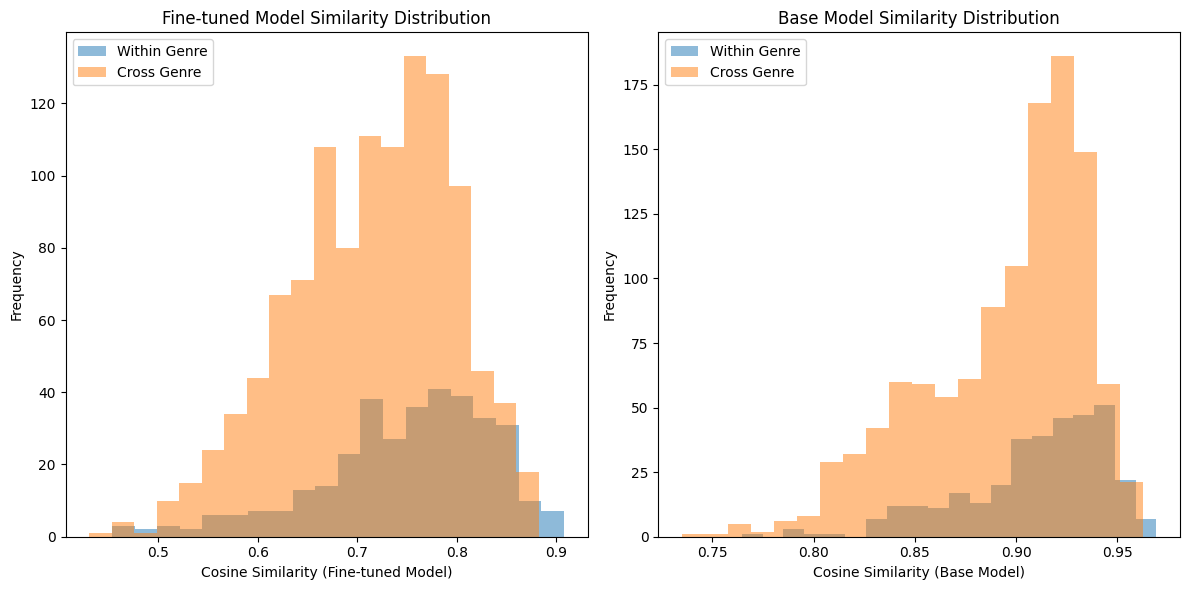


=== Classification Performance ===
Created 1085 test pairs
Label distribution: Counter({1: 737, 0: 348})

=== Testing different thresholds (FLIPPED LOGIC) ===
    threshold  f1_finetuned  accuracy_finetuned   f1_base  accuracy_base  pred_0_count  pred_1_count
0        0.00      0.404501            0.679263  0.404501       0.679263             0          1085
1        0.05      0.404501            0.679263  0.404501       0.679263             0          1085
2        0.10      0.404501            0.679263  0.404501       0.679263             0          1085
3        0.15      0.404501            0.679263  0.404501       0.679263             0          1085
4        0.20      0.404501            0.679263  0.404501       0.679263             0          1085
5        0.25      0.404501            0.679263  0.404501       0.679263             0          1085
6        0.30      0.404501            0.679263  0.404501       0.679263             0          1085
7        0.35      0.404501     

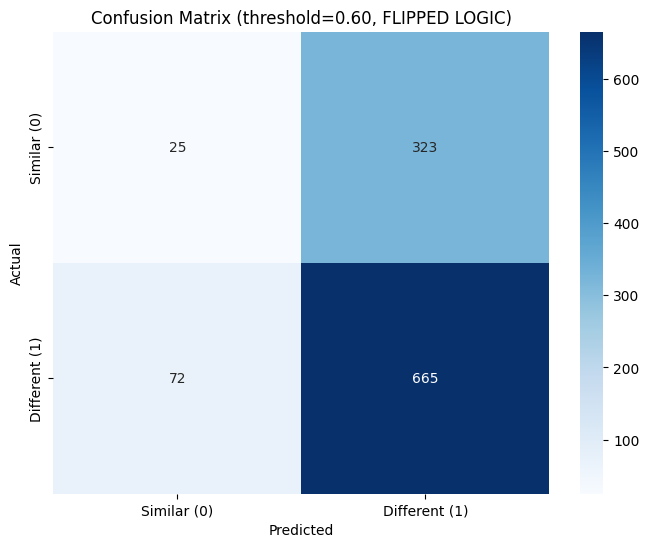


=== Confusion Matrix (FLIPPED LOGIC) ===
[[ 25 323]
 [ 72 665]]

=== Classification Report (FLIPPED LOGIC) ===
              precision    recall  f1-score   support

           0       0.26      0.07      0.11       348
           1       0.67      0.90      0.77       737

    accuracy                           0.64      1085
   macro avg       0.47      0.49      0.44      1085
weighted avg       0.54      0.64      0.56      1085



+---------------------------------------------------------------------------+
|     Genre     |     Mode      | Accuracy | F1 Micro | F1 Weighted | F1 Macro | Recall |Precision |
+---------------------------------------------------------------------------+
|     民俗与传统     |   per-genre   |  0.3333  |  0.0000  |   0.0000    |  0.0000  | 0.0000 |  0.0000  |
+---------------------------------------------------------------------------+
|     爱与浪漫      |   per-genre   |  0.0719  |  0.0000  |   0.0000    |  0.0000  | 0.0000 |  0.0000  |
|     爱与浪漫      |  cro

In [34]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sentence_transformers import SentenceTransformer, util
from sklearn import metrics

# =================== Load Song Data ===================
with open('testing_data_2.json', 'r', encoding='utf-8') as file:
    song_data = json.load(file)

print(f"Data loaded: {len(song_data)} songs")
print(f"Data type: {type(song_data)}")

# Extract song information directly
songs = []
for key, song in song_data.items():
    try:
        # Check if this is a valid song entry with lyrics
        if isinstance(song, dict) and 'lyrics' in song:
            # Add the ID to the song for reference
            song['id'] = key
            songs.append(song)
        else:
            print(f"Warning: Skipping entry {key} - not a valid song")
    except Exception as e:
        print(f"Error processing song {key}: {e}")

print(f"Extracted {len(songs)} valid songs for analysis")

# Count genres in the dataset
genre_counts = Counter()
for song in songs:
    genre = song.get('genre', ['Unknown'])
    if isinstance(genre, list) and len(genre) > 0:
        genre_counts[genre[0]] += 1
    else:
        genre_counts['Unknown'] += 1

print("\nGenre distribution:")
for genre, count in genre_counts.most_common():
    print(f"  {genre}: {count} songs")

# =================== Load Models ===================
try:
    model_path = "/content/drive/MyDrive/LLM Project/finetuned_chinese_roberta"
    print(f"\nLoading model from: {model_path}")
    model = SentenceTransformer(model_path)
    model.eval()

    print("Loading base model for comparison")
    base_model = SentenceTransformer('hfl/chinese-roberta-wwm-ext')
    base_model.eval()
except Exception as e:
    print(f"Error loading models: {e}")
    print("Falling back to a simple model")
    model = base_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    model.eval()
    base_model.eval()

# =================== Compute Song Embeddings ===================
song_embeddings = []

for idx, song in enumerate(songs):
    try:
        # Extract key song information
        lyrics = song.get('lyrics', '')
        if not lyrics:
            print(f"Warning: Skipping song {song.get('id', idx)} - empty lyrics")
            continue

        title = song.get('title', f"Song {song.get('id', idx)}")

        # Extract genre
        genre = song.get('genre', ['Unknown'])
        if isinstance(genre, list) and len(genre) > 0:
            genre = genre[0]
        else:
            genre = str(genre)

        # Compute embeddings
        emb_ft = model.encode(lyrics, convert_to_tensor=True)
        emb_base = base_model.encode(lyrics, convert_to_tensor=True)

        # Store song with embeddings
        song_embeddings.append({
            'id': song.get('id', str(idx)),
            'title': title,
            'genre': genre,
            'lyrics_preview': lyrics[:50] + "..." if len(lyrics) > 50 else lyrics,
            'embedding_ft': emb_ft,
            'embedding_base': emb_base
        })

        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1} songs...")

    except Exception as e:
        print(f"Error computing embeddings for song {song.get('id', idx)}: {e}")

print(f"\nComputed embeddings for {len(song_embeddings)} songs")

# =================== Analyze Song Similarity ===================
# 1. Compute similarity distribution within genres
# 2. Compare to similarity distribution across genres

# Group songs by genre
genre_groups = {}
for song in song_embeddings:
    genre = song['genre']
    if genre not in genre_groups:
        genre_groups[genre] = []
    genre_groups[genre].append(song)

# Calculate similarity statistics
print("\n=== Similarity Analysis by Genre ===")
genre_stats = {}

# Function to compute similarity matrix for a group of songs
def compute_similarity_matrix(songs, model_type='ft'):
    n = len(songs)
    sim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):  # Only upper triangle
            emb_i = songs[i][f'embedding_{model_type}']
            emb_j = songs[j][f'embedding_{model_type}']
            sim = util.cos_sim(emb_i, emb_j).item()
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim  # Symmetric

    # Set diagonal to 1 (self-similarity)
    np.fill_diagonal(sim_matrix, 1.0)
    return sim_matrix

# Compute within-genre and cross-genre similarity
within_genre_sims_ft = []
within_genre_sims_base = []
cross_genre_sims_ft = []
cross_genre_sims_base = []

# Calculate within-genre similarity
for genre, group in genre_groups.items():
    if len(group) < 2:
        print(f"Skipping genre '{genre}' - insufficient songs")
        continue

    # Compute similarity matrix for this genre
    sim_matrix_ft = compute_similarity_matrix(group, 'ft')
    sim_matrix_base = compute_similarity_matrix(group, 'base')

    # Get upper triangle values (excluding diagonal)
    triu_indices = np.triu_indices(len(group), k=1)
    genre_sims_ft = sim_matrix_ft[triu_indices]
    genre_sims_base = sim_matrix_base[triu_indices]

    # Add to overall within-genre similarities
    within_genre_sims_ft.extend(genre_sims_ft)
    within_genre_sims_base.extend(genre_sims_base)

    # Store stats for this genre
    genre_stats[genre] = {
        'count': len(group),
        'mean_sim_ft': np.mean(genre_sims_ft),
        'std_sim_ft': np.std(genre_sims_ft),
        'min_sim_ft': np.min(genre_sims_ft),
        'max_sim_ft': np.max(genre_sims_ft),
        'mean_sim_base': np.mean(genre_sims_base),
        'std_sim_base': np.std(genre_sims_base)
    }

    print(f"\nGenre: {genre} ({len(group)} songs)")
    print(f"  Mean similarity (fine-tuned): {np.mean(genre_sims_ft):.4f} ± {np.std(genre_sims_ft):.4f}")
    print(f"  Mean similarity (base model): {np.mean(genre_sims_base):.4f} ± {np.std(genre_sims_base):.4f}")
    print(f"  Min/Max similarity (fine-tuned): {np.min(genre_sims_ft):.4f}/{np.max(genre_sims_ft):.4f}")

# Calculate cross-genre similarity
genre_pairs = []
for i, (genre1, group1) in enumerate(genre_groups.items()):
    for genre2, group2 in list(genre_groups.items())[i+1:]:
        genre_pairs.append((genre1, genre2, group1, group2))

for genre1, genre2, group1, group2 in genre_pairs:
    cross_sims_ft = []
    cross_sims_base = []

    for song1 in group1:
        for song2 in group2:
            sim_ft = util.cos_sim(song1['embedding_ft'], song2['embedding_ft']).item()
            sim_base = util.cos_sim(song1['embedding_base'], song2['embedding_base']).item()

            cross_sims_ft.append(sim_ft)
            cross_sims_base.append(sim_base)

    cross_genre_sims_ft.extend(cross_sims_ft)
    cross_genre_sims_base.extend(cross_sims_base)

    print(f"\nCross-Genre: {genre1} vs {genre2} ({len(cross_sims_ft)} comparisons)")
    print(f"  Mean similarity (fine-tuned): {np.mean(cross_sims_ft):.4f} ± {np.std(cross_sims_ft):.4f}")
    print(f"  Mean similarity (base model): {np.mean(cross_sims_base):.4f} ± {np.std(cross_sims_base):.4f}")

# =================== Visualize Similarity Distributions ===================
# Plot histograms of within-genre vs cross-genre similarity
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(within_genre_sims_ft, bins=20, alpha=0.5, label='Within Genre')
plt.hist(cross_genre_sims_ft, bins=20, alpha=0.5, label='Cross Genre')
plt.xlabel('Cosine Similarity (Fine-tuned Model)')
plt.ylabel('Frequency')
plt.title('Fine-tuned Model Similarity Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(within_genre_sims_base, bins=20, alpha=0.5, label='Within Genre')
plt.hist(cross_genre_sims_base, bins=20, alpha=0.5, label='Cross Genre')
plt.xlabel('Cosine Similarity (Base Model)')
plt.ylabel('Frequency')
plt.title('Base Model Similarity Distribution')
plt.legend()

plt.tight_layout()
plt.savefig('similarity_distributions.png')
plt.show()

# =================== Test Classification Performance ===================
# Create a dataset of song pairs with labels for testing
# Label 0 = same genre (similar), Label 1 = different genre (dissimilar)

# We can use the within-genre and cross-genre similarities calculated earlier
print("\n=== Classification Performance ===")

# Create test pairs
test_pairs = []

# Within-genre pairs (Label 0 = similar)
pair_idx = 0
for genre, group in genre_groups.items():
    if len(group) < 2:
        continue

    for i in range(len(group)):
        for j in range(i+1, len(group)):
            # Get song information
            song1 = group[i]
            song2 = group[j]

            # Compute similarity
            sim_ft = util.cos_sim(song1['embedding_ft'], song2['embedding_ft']).item()
            sim_base = util.cos_sim(song1['embedding_base'], song2['embedding_base']).item()

            # Store pair
            test_pairs.append({
                'id': pair_idx,
                'song1_id': song1['id'],
                'song2_id': song2['id'],
                'title1': song1['title'],
                'title2': song2['title'],
                'genre1': song1['genre'],
                'genre2': song2['genre'],
                'mode': 'per-genre',
                'true_label': 0,  # Same genre = similar
                'similarity_finetuned': sim_ft,
                'similarity_base': sim_base
            })
            pair_idx += 1

# Cross-genre pairs (Label 1 = different)
for genre1, genre2, group1, group2 in genre_pairs:
    # Limit the number of cross-genre pairs to avoid imbalance
    max_pairs = min(len(group1) * len(group2), 100)
    pair_count = 0

    for song1 in group1:
        for song2 in group2:
            # Check if we've reached the limit
            if pair_count >= max_pairs:
                break

            # Compute similarity
            sim_ft = util.cos_sim(song1['embedding_ft'], song2['embedding_ft']).item()
            sim_base = util.cos_sim(song1['embedding_base'], song2['embedding_base']).item()

            # Store pair
            test_pairs.append({
                'id': pair_idx,
                'song1_id': song1['id'],
                'song2_id': song2['id'],
                'title1': song1['title'],
                'title2': song2['title'],
                'genre1': song1['genre'],
                'genre2': song2['genre'],
                'mode': 'cross-genre',
                'true_label': 1,  # Different genre = different
                'similarity_finetuned': sim_ft,
                'similarity_base': sim_base
            })
            pair_idx += 1
            pair_count += 1

# Convert to DataFrame
test_df = pd.DataFrame(test_pairs)
print(f"Created {len(test_df)} test pairs")

# Label distribution
label_counter = Counter(test_df['true_label'])
print(f"Label distribution: {label_counter}")

# =================== Test Different Thresholds with FLIPPED Logic ===================
print("\n=== Testing different thresholds (FLIPPED LOGIC) ===")
thresholds = np.arange(0.0, 1.0, 0.05)
results_by_threshold = []

for thresh in thresholds:
    # Fine-tuned model predictions - FLIPPED LOGIC: lower similarity means similar (0)
    preds_ft = [0 if sim < thresh else 1 for sim in test_df['similarity_finetuned']]
    f1_ft = metrics.f1_score(test_df['true_label'], preds_ft, average='macro')
    acc_ft = metrics.accuracy_score(test_df['true_label'], preds_ft)
    pred_counts = Counter(preds_ft)

    # Base model predictions - FLIPPED LOGIC
    preds_base = [0 if sim < thresh else 1 for sim in test_df['similarity_base']]
    f1_base = metrics.f1_score(test_df['true_label'], preds_base, average='macro')
    acc_base = metrics.accuracy_score(test_df['true_label'], preds_base)

    results_by_threshold.append({
        'threshold': thresh,
        'f1_finetuned': f1_ft,
        'accuracy_finetuned': acc_ft,
        'f1_base': f1_base,
        'accuracy_base': acc_base,
        'pred_0_count': pred_counts.get(0, 0),
        'pred_1_count': pred_counts.get(1, 0)
    })

thresh_df = pd.DataFrame(results_by_threshold)
print(thresh_df.to_string())

# Find best thresholds
best_thresh_ft = thresh_df.loc[thresh_df['f1_finetuned'].idxmax(), 'threshold']
best_f1_ft = thresh_df.loc[thresh_df['f1_finetuned'].idxmax(), 'f1_finetuned']
best_thresh_base = thresh_df.loc[thresh_df['f1_base'].idxmax(), 'threshold']
best_f1_base = thresh_df.loc[thresh_df['f1_base'].idxmax(), 'f1_base']

print(f"\nBest threshold (fine-tuned): {best_thresh_ft:.2f} with F1: {best_f1_ft:.4f}")
print(f"Best threshold (base): {best_thresh_base:.2f} with F1: {best_f1_base:.4f}")

# =================== Make Predictions with Best Threshold - FLIPPED LOGIC ===================
# Add predictions with best threshold - FLIPPED LOGIC
test_df['prediction'] = [0 if sim < best_thresh_ft else 1 for sim in test_df['similarity_finetuned']]
test_df['correct'] = test_df['prediction'] == test_df['true_label']

# Confusion matrix with best threshold
conf_matrix = metrics.confusion_matrix(test_df['true_label'], test_df['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Similar (0)", "Different (1)"],
            yticklabels=["Similar (0)", "Different (1)"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (threshold={best_thresh_ft:.2f}, FLIPPED LOGIC)')
plt.savefig('confusion_matrix_flipped_new.png')
plt.show()

print("\n=== Confusion Matrix (FLIPPED LOGIC) ===")
print(conf_matrix)
print("\n=== Classification Report (FLIPPED LOGIC) ===")
print(metrics.classification_report(test_df['true_label'], test_df['prediction']))

# =================== Analysis by Genre and Mode ===================
# Function to calculate metrics for a subset of data with a given threshold
def calculate_metrics(df_subset, threshold):
    # Handle empty subsets
    if len(df_subset) == 0:
        return {
            'Accuracy': 0.0,
            'F1 Micro': 0.0,
            'F1 Weighted': 0.0,
            'F1 Macro': 0.0,
            'Recall': 0.0,
            'Precision': 0.0
        }

    y_true = df_subset['true_label']
    # FLIPPED LOGIC: lower similarity means class 0
    y_pred = [0 if sim < threshold else 1 for sim in df_subset['similarity_finetuned']]

    # Handle cases where there might be only one class in the true labels or predictions
    unique_true = np.unique(y_true)
    unique_pred = np.unique(y_pred)

    # Default values in case of errors
    f1_micro = f1_weighted = f1_macro = recall = precision = 0.0

    # Only calculate metrics if we have both classes
    if len(unique_true) > 1 and len(unique_pred) > 1:
        f1_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f1_weighted = metrics.f1_score(y_true, y_pred, average='weighted')
        f1_macro = metrics.f1_score(y_true, y_pred, average='macro')
        recall = metrics.recall_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred)
    else:
        # If we only have one class, handle specially
        if 1 in unique_pred:
            # All predictions are class 1
            recall = 0.0 if 0 in unique_true else 1.0
            precision = sum(y_true == 1) / len(y_true) if 1 in unique_pred else 0.0
        else:
            # All predictions are class 0
            recall = 1.0 if 0 in unique_true else 0.0
            precision = sum(y_true == 0) / len(y_true) if 0 in unique_pred else 0.0

    return {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'F1 Micro': f1_micro,
        'F1 Weighted': f1_weighted,
        'F1 Macro': f1_macro,
        'Recall': recall,
        'Precision': precision
    }

# Define key genres to ensure they're all included in the metrics
key_genres = ['民俗与传统', '爱与浪漫', '生活与反思', '社会与现实', '风景与旅程']

# Get unique genres and modes
unique_genres = pd.concat([test_df['genre1'], test_df['genre2']]).unique()
unique_modes = test_df['mode'].unique()

# Create metrics for each genre and mode
genre_mode_metrics = []

# First, add overall metrics
overall_metrics = calculate_metrics(test_df, best_thresh_ft)
genre_mode_metrics.append({
    'Genre': 'Overall',
    'Mode': 'all',
    **overall_metrics
})

# Process by mode first
for mode in unique_modes:
    mode_subset = test_df[test_df['mode'] == mode]
    mode_metrics = calculate_metrics(mode_subset, best_thresh_ft)
    genre_mode_metrics.append({
        'Genre': 'Overall',
        'Mode': mode,
        **mode_metrics
    })

# Process each key genre
for genre in key_genres:
    # Handle the case where a key genre isn't in unique_genres
    if genre not in unique_genres:
        print(f"Warning: Key genre '{genre}' not found in dataset")
        continue

    # Get all pairs where genre1 is the current genre
    genre_subset = test_df[test_df['genre1'] == genre]

    # Skip if no pairs found
    if len(genre_subset) == 0:
        continue

    # Calculate metrics for this genre
    genre_metrics = calculate_metrics(genre_subset, best_thresh_ft)
    genre_mode_metrics.append({
        'Genre': genre,
        'Mode': 'all',
        **genre_metrics
    })

    # Per genre, per mode
    for mode in unique_modes:
        mode_subset = genre_subset[genre_subset['mode'] == mode]
        # Skip if no pairs in this mode
        if len(mode_subset) == 0:
            continue

        mode_metrics = calculate_metrics(mode_subset, best_thresh_ft)
        genre_mode_metrics.append({
            'Genre': genre,
            'Mode': mode,
            **mode_metrics
        })

# Create metrics dataframe and format it
metrics_df = pd.DataFrame(genre_mode_metrics)

# Round all numeric columns to 4 decimal places
numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns
metrics_df[numeric_cols] = metrics_df[numeric_cols].round(4)

# Custom formatting for the table
print("\n")
print("+" + "-"*75 + "+")
print("|{:^15}|{:^15}|{:^10}|{:^10}|{:^13}|{:^10}|{:^8}|{:^10}|".format(
    "Genre", "Mode", "Accuracy", "F1 Micro", "F1 Weighted", "F1 Macro", "Recall", "Precision"))
print("+" + "-"*75 + "+")

# Set the genre and mode order to match the example
genre_order = ['民俗与传统', '爱与浪漫', '生活与反思', '社会与现实', '风景与旅程', 'Overall']
mode_order = ['per-genre', 'cross-genre']

# First collect all rows
rows_by_genre_mode = {}
for _, row in metrics_df.iterrows():
    genre = row['Genre']
    mode = row['Mode']

    # Skip 'all' mode for the custom table
    if mode == 'all':
        continue

    # Create a key for sorting
    key = (genre, mode)
    rows_by_genre_mode[key] = row

# Create the table following the specific ordering
for genre in genre_order:
    if genre not in unique_genres and genre != 'Overall':
        continue

    for mode in mode_order:
        key = (genre, mode)
        if key in rows_by_genre_mode:
            row = rows_by_genre_mode[key]
            print("|{:^15}|{:^15}|{:^10.4f}|{:^10.4f}|{:^13.4f}|{:^10.4f}|{:^8.4f}|{:^10.4f}|".format(
                genre, mode,
                row['Accuracy'], row['F1 Micro'], row['F1 Weighted'],
                row['F1 Macro'], row['Recall'], row['Precision']))

    # Add separator line after each genre except the last one
    if genre != genre_order[-1] and genre in unique_genres:
        print("+" + "-"*75 + "+")

print("+" + "-"*75 + "+")

# Save results and metrics
test_df.to_csv('song_similarity_results.csv', index=False)
metrics_df.to_csv('song_similarity_metrics.csv', index=False)
print("\nResults saved to 'song_similarity_results.csv'")
print("Metrics saved to 'song_similarity_metrics.csv'")